# Análise exploratória dos dados dos candidatos SISU/UFRPE

## Importando as bibliotecas necessárias

In [6]:
# Biblioteca para trabalhar com PDFs
import fitz # PyMuPDF

# Manipulação de dados tabulares
import pandas as pd

# Manipulação de arquivos e sistema de arquivos
import os

# Expressões regulares para manipulação de texto
import re

# Criação de gráficos e visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Geração de identificadores únicos
import uuid

In [9]:
# Função para processar cada página e extrair os dados relevantes
def processar_pdf(caminho_arquivo):
    # Abrindo o arquivo PDF
    documento_pdf = fitz.open(caminho_arquivo)
    dados_totais = []

    # Extraindo o texto de cada página
    for num_pagina in range(len(documento_pdf)):
        pagina = documento_pdf.load_page(num_pagina)
        texto = pagina.get_text()

        # Processando o texto da página
        curso_turno = re.search(r"CURSO: (.+?)- (MATUTINO|VESPERTINO|NOTURNO|INTEGRAL)", texto)
        if curso_turno:
            curso = curso_turno.group(1).strip()
            turno = curso_turno.group(2).strip()
        else:
            continue  # Se não encontrar curso e turno, pula para a próxima página

        # Encontrando as linhas com os dados dos candidatos
        linhas = texto.split('\n')
        linhas_dados = [linha for linha in linhas if re.match(r"\d{3}\s+\d{5}\*\*\*\*\d{2}\s+\w+", linha)]

        # Processando cada linha de dados
        for linha in linhas_dados:
            encontrado = re.search(r"(\d{3})\s+(\d{5}\*\*\*\*\d{2})\s+(\w+)\s+(.+?)\s+(\d+\.\d{2})", linha)
            if encontrado:
                seq, cpf, cota, nome, nota = encontrado.groups()
                dados_totais.append([seq, cpf, curso, turno, cota, float(nota)])

    # Fechando o documento PDF após o processamento
    documento_pdf.close()
    return dados_totais

In [10]:
def ler_pdfs(caminho_pasta):
    dados = []
    arquivos_processados = []

    # Iterando sobre cada arquivo no diretório especificado
    for arquivo in os.listdir(caminho_pasta):
        # Verificando se o arquivo é um PDF
        if arquivo.endswith('.pdf'):
            caminho_arquivo = os.path.join(caminho_pasta, arquivo)
            # Processando o arquivo PDF
            dados_pdf = processar_pdf(caminho_arquivo)
            dados.extend(dados_pdf)
            arquivos_processados.append(arquivo)

    # Imprimindo os arquivos PDF processados
    print("\nArquivos PDF processados:")
    print("\n".join(arquivos_processados))

    # Criando um DataFrame com os dados coletados e removendo colunas desnecessárias
    df = pd.DataFrame(dados, columns=["Seq", "CPF", "Curso", "Turno", "Cota", "Nota"])
    df.drop(['Seq', 'CPF'], axis=1, inplace=True)

    # Gerando um nome de arquivo aleatório para o arquivo CSV
    nome_aleatorio = str(uuid.uuid4()) + '.csv'
    caminho_csv = os.path.join(caminho_pasta, nome_aleatorio)
    # Salvando os dados em um arquivo CSV
    df.to_csv(caminho_csv, index=False)
    print(f"Dados unificados salvos em: {caminho_csv}")

    return df

# Caminho da pasta onde os PDFs estão armazenados
caminho_pasta = './'
df = ler_pdfs(caminho_pasta)


Arquivos PDF processados:
RECIFE - RELACAO DOS CANDIDATOS INGRESSANTES SISU 2022-1.pdf
RECIFE - RELACAO DOS CANDIDATOS INGRESSANTES SISU 2022-2.pdf
SEDE - RELACAO DOS CANDIDATOS INGRESSANTES SISU 2021_1.pdf
SEDE - RELACAO DOS CANDIDATOS INGRESSANTES SISU 2021_2.pdf
SEDE_Lista_Convocacao_chamada_regular_2023.pdf
Dados unificados salvos em: ./ad5793f8-09c8-4c3c-8c37-dadb5fe20019.csv


In [11]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4399 entries, 0 to 4398
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Curso   4399 non-null   object 
 1   Turno   4399 non-null   object 
 2   Cota    4399 non-null   object 
 3   Nota    4399 non-null   float64
dtypes: float64(1), object(3)
memory usage: 137.6+ KB


,Curso,Turno,Cota,Nota
0,BACHARELADO ADMINISTRACAO,MATUTINO,L2,601.00
1,BACHARELADO ADMINISTRACAO,MATUTINO,L6,611.23
2,BACHARELADO ADMINISTRACAO,MATUTINO,A0,658.19
3,BACHARELADO ADMINISTRACAO,MATUTINO,A0,677.43
4,BACHARELADO ADMINISTRACAO,MATUTINO,L1,632.79
5,BACHARELADO ADMINISTRACAO,MATUTINO,L5,667.33
6,BACHARELADO ADMINISTRACAO,MATUTINO,L2,599.00
7,BACHARELADO ADMINISTRACAO,MATUTINO,A0,646.00
8,BACHARELADO ADMINISTRACAO,MATUTINO,A0,663.02
9,BACHARELADO ADMINISTRACAO,MATUTINO,L2,602.97


## Análise da menor nota por curso e turno

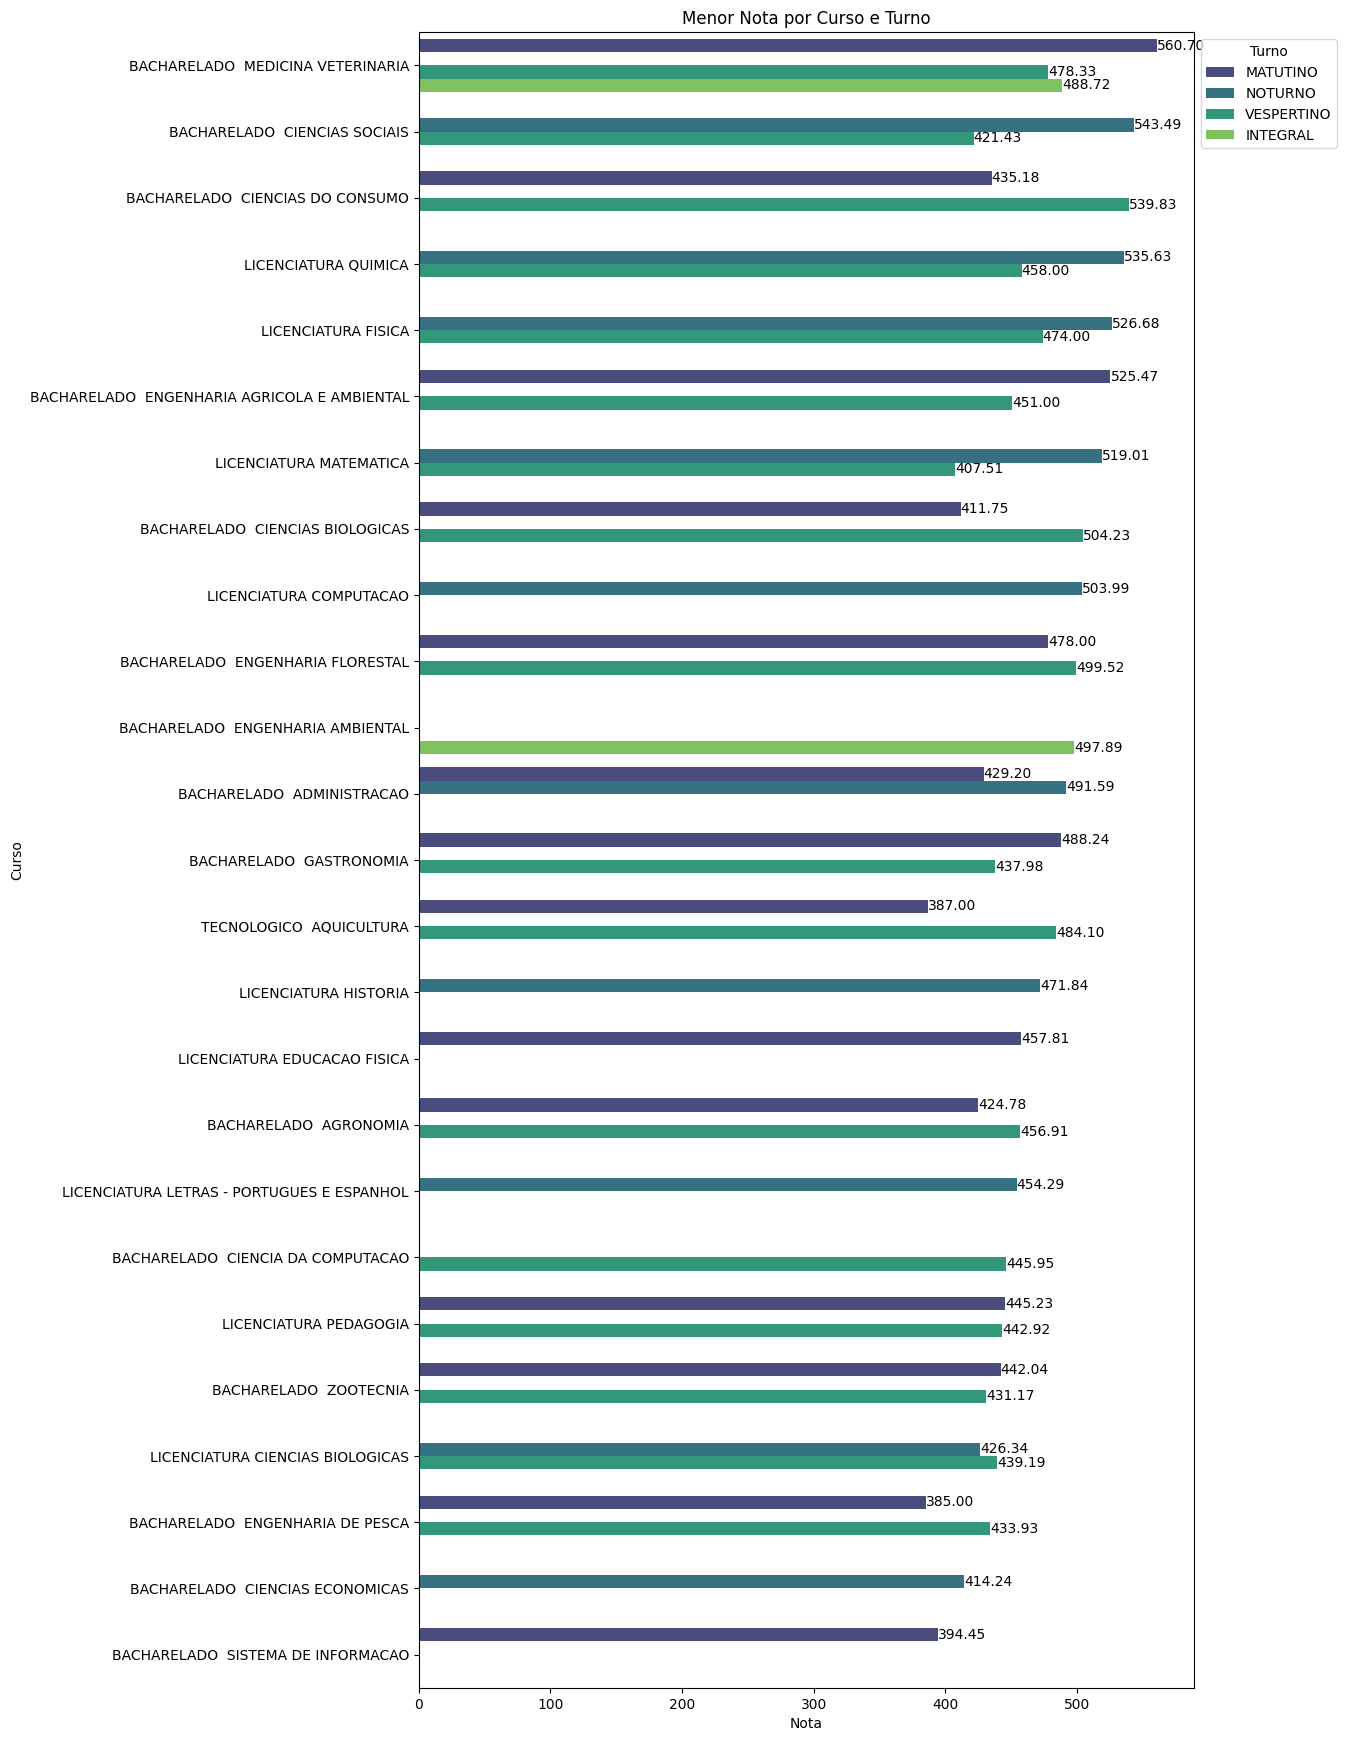

In [12]:
def plotar_menor_nota_curso_turno(df):
    # Calculando a menor nota por curso e turno
    menor_nota = df.groupby(['Curso', 'Turno'])['Nota'].min().reset_index()

    # Ordenando os resultados para melhor visualização
    menor_nota_ordenada = menor_nota.sort_values('Nota', ascending=False)

    # Configurando o tamanho do gráfico
    plt.figure(figsize=(10, len(menor_nota_ordenada) / 2))

    # Criando o gráfico de barras
    grafico = sns.barplot(
        x='Nota', 
        y='Curso', 
        hue='Turno', 
        data=menor_nota_ordenada,
        palette='viridis'
    )

    # Adicionando as anotações com as menores notas
    for p in grafico.patches:
        grafico.annotate(
            format(p.get_width(), '.2f'), 
            (p.get_width(), p.get_y() + p.get_height() / 2), 
            ha='left', 
            va='center'
        )

    # Adicionando título e labels
    plt.title('Menor Nota por Curso e Turno')
    plt.xlabel('Nota')
    plt.ylabel('Curso')
    plt.legend(title='Turno', loc='upper left', bbox_to_anchor=(1, 1))

    # Exibindo o gráfico
    plt.show()

# Exemplo de uso da função
# Supondo que 'df' é o seu DataFrame
plotar_menor_nota_curso_turno(df)

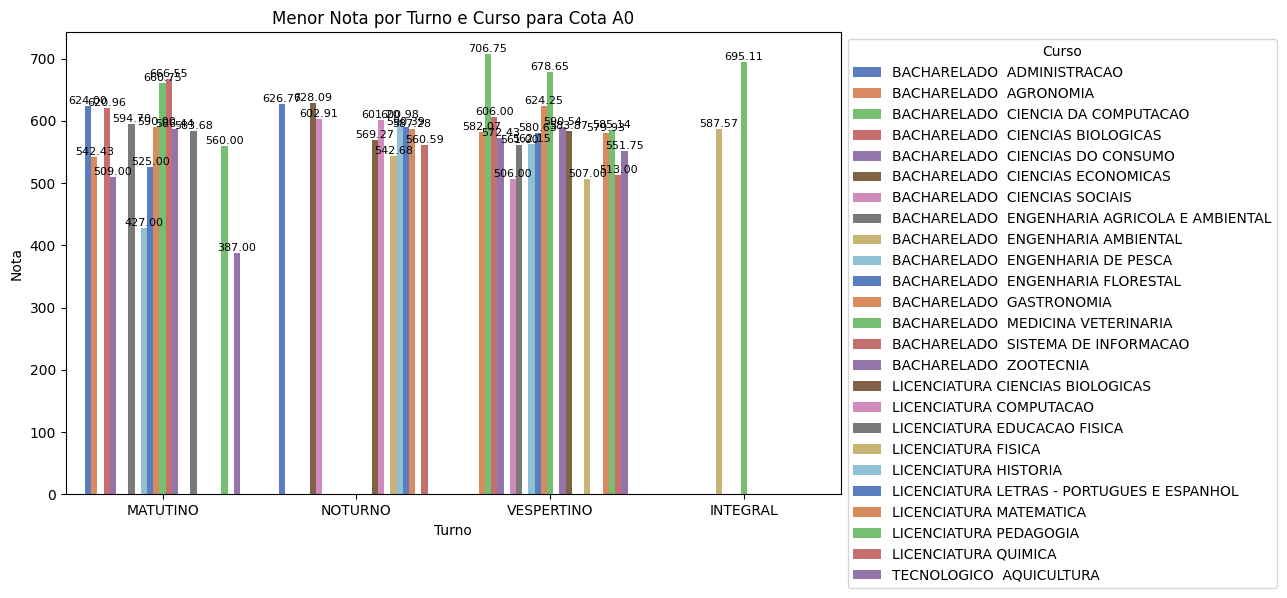

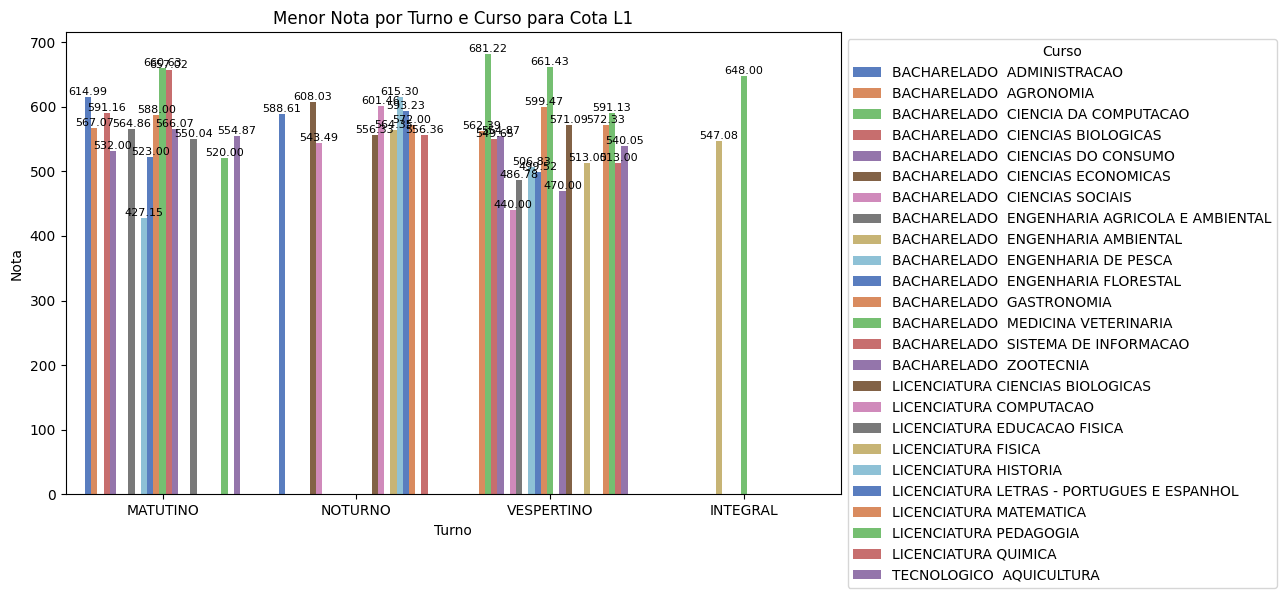

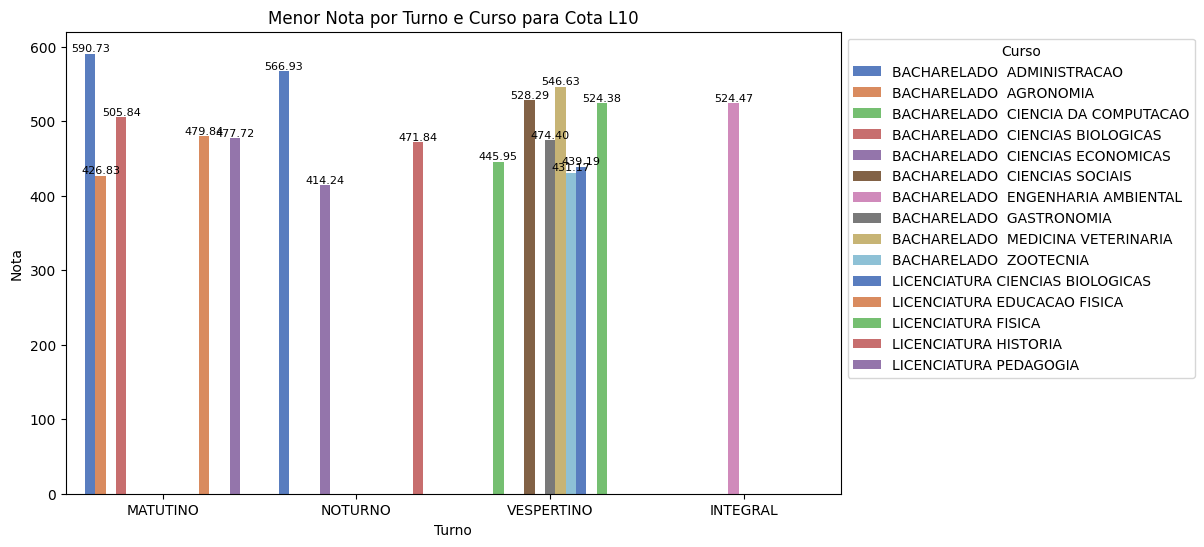

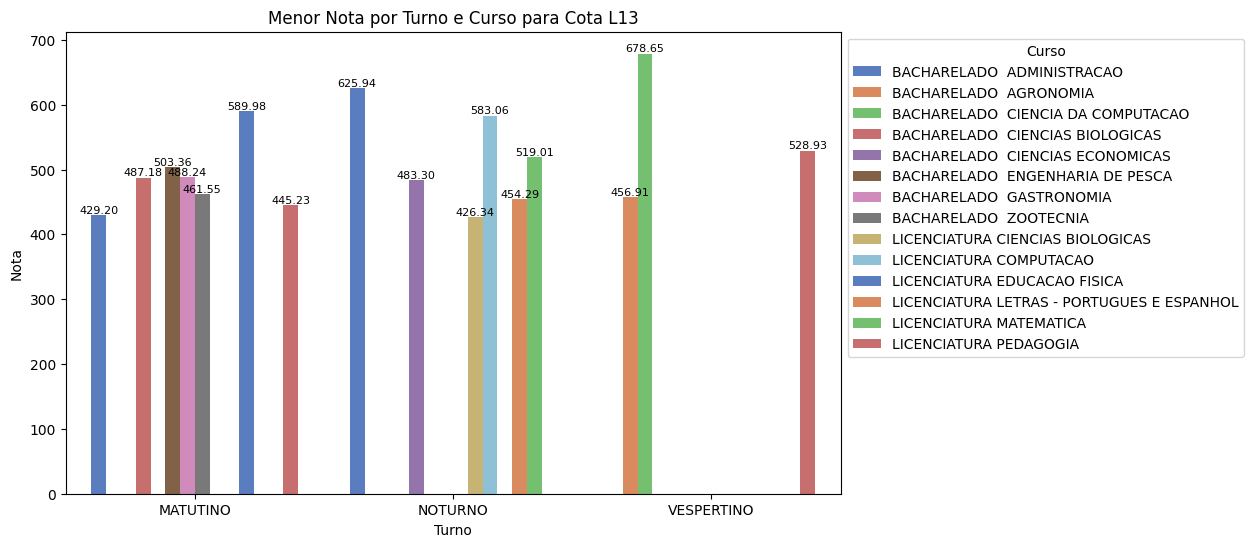

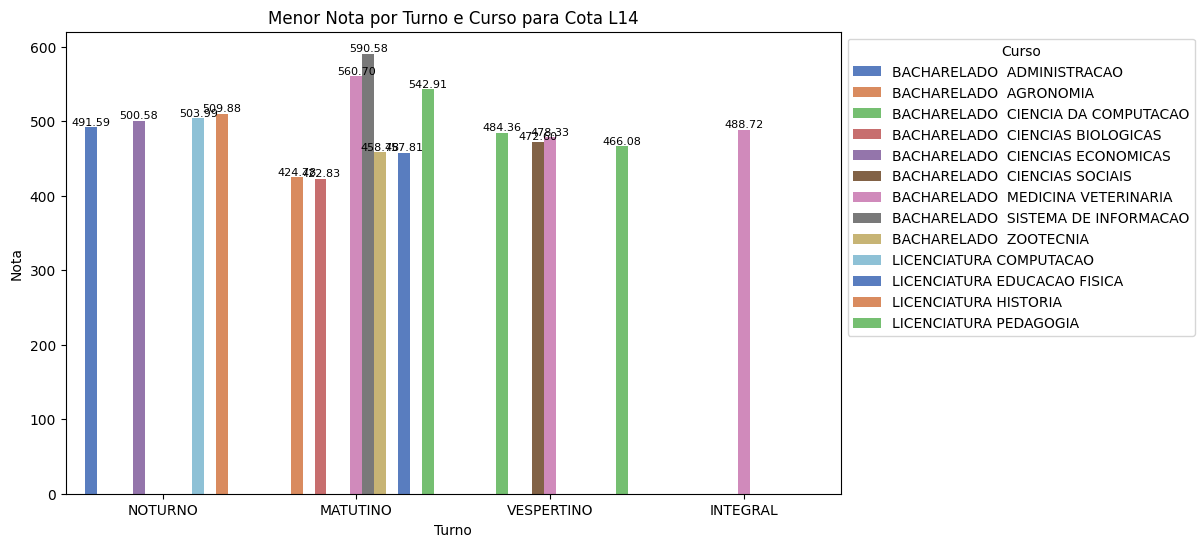

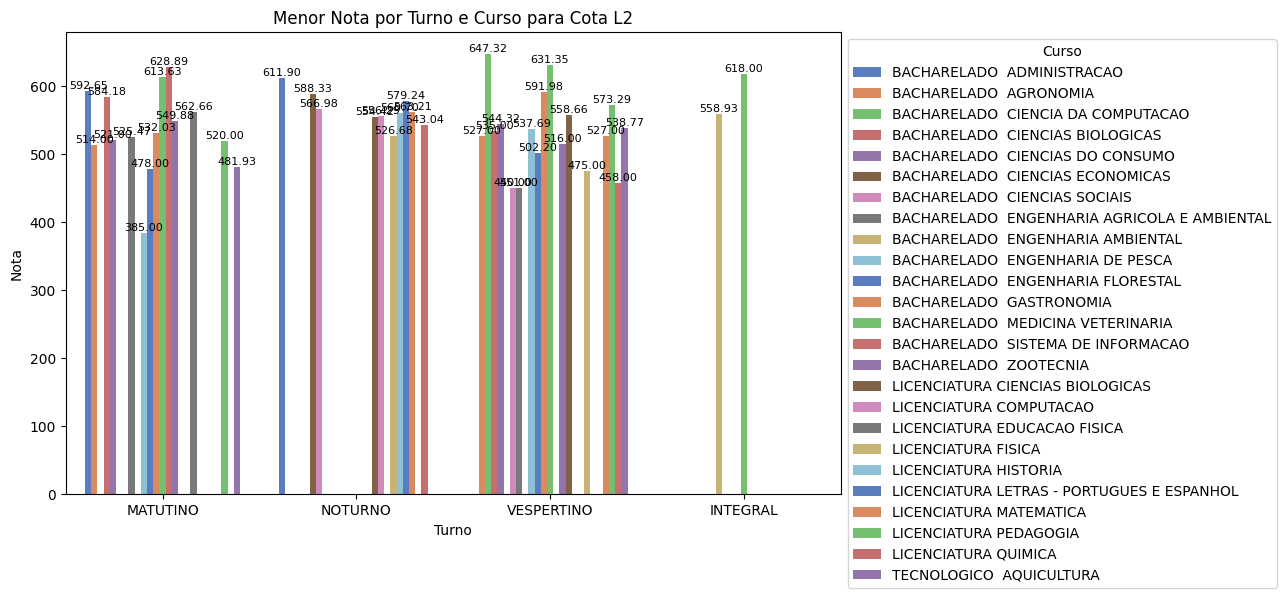

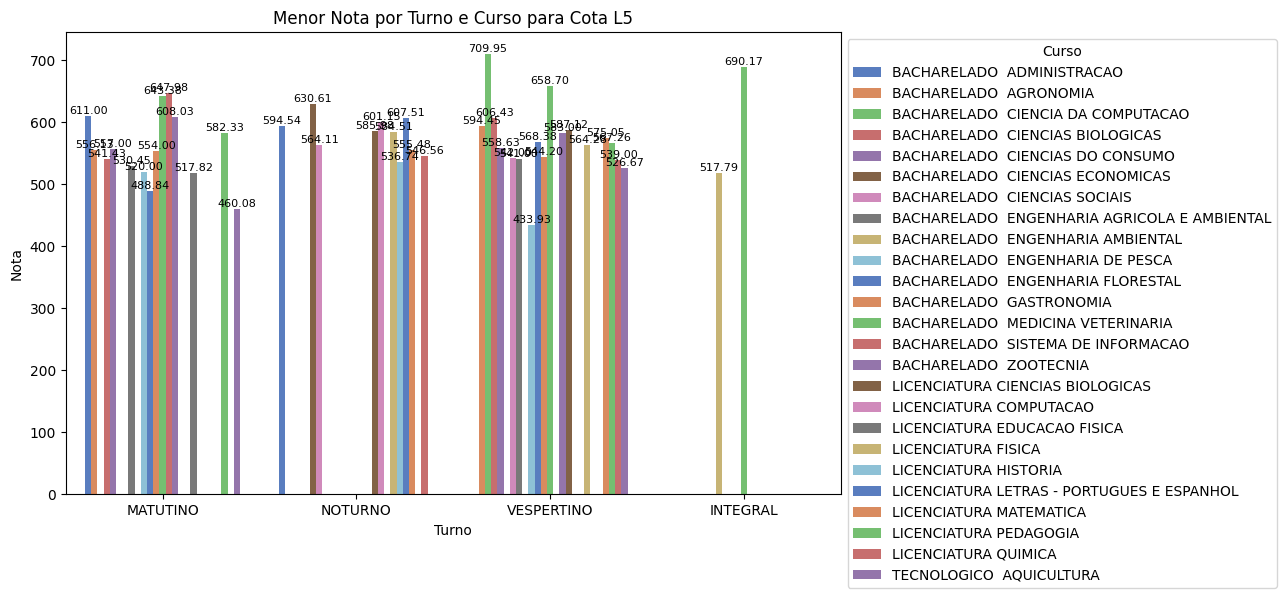

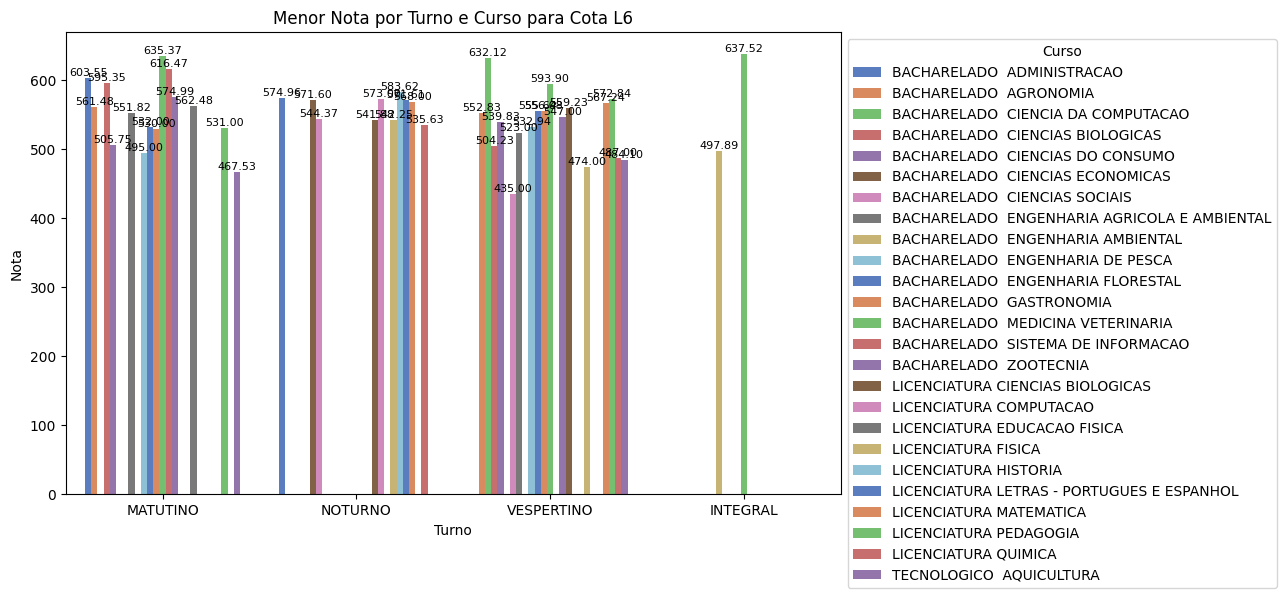

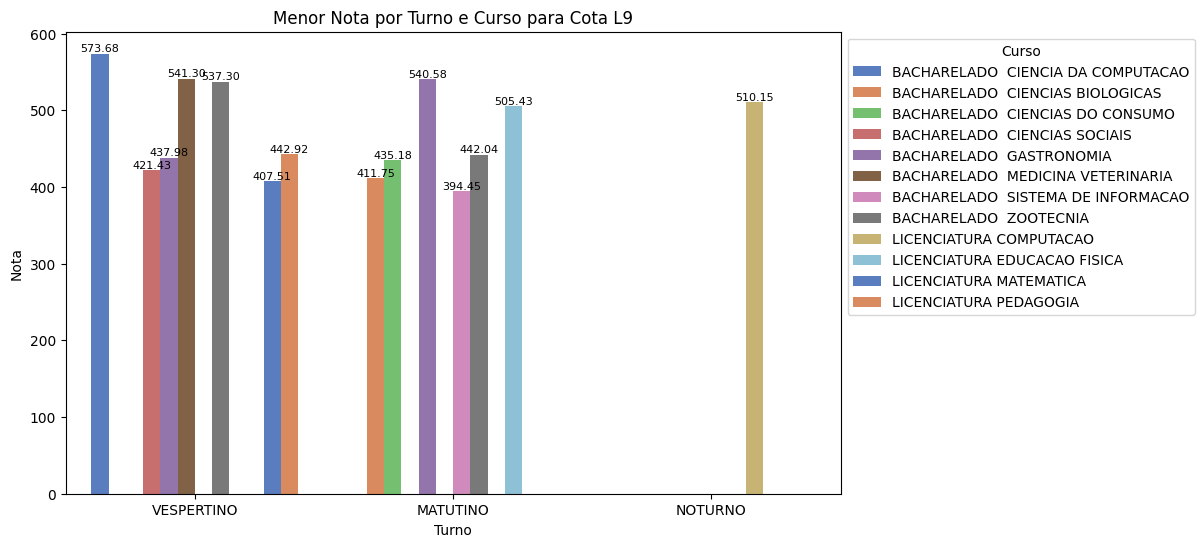

In [13]:
def plotar_por_cota(df):
    # Calculando a menor nota por cota, curso e turno
    menor_nota = df.groupby(['Cota', 'Curso', 'Turno'])['Nota'].min().reset_index()

    # Obtendo cotas únicas
    cotas_unicas = menor_nota['Cota'].unique()

    # Criando um gráfico para cada tipo de cota
    for cota in cotas_unicas:
        dados_cota = menor_nota[menor_nota['Cota'] == cota]

        plt.figure(figsize=(10, 6))
        grafico = sns.barplot(
            x='Turno', 
            y='Nota', 
            hue='Curso', 
            data=dados_cota,
            palette='muted'
        )

        # Adicionando as anotações com as menores notas
        for p in grafico.patches:
            grafico.annotate(
                format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', 
                va='bottom',
                fontsize=8  # Reduzindo o tamanho da fonte
            )

        # Adicionando título e rótulos
        plt.title(f'Menor Nota por Turno e Curso para Cota {cota}')
        plt.xlabel('Turno')
        plt.ylabel('Nota')
        plt.legend(title='Curso', loc='upper left', bbox_to_anchor=(1, 1))

        # Exibindo o gráfico
        plt.show()

# Exemplo de uso da função
# Supondo que 'df' é o seu DataFrame
plotar_por_cota(df)

## Análise da menor nota por tipo de cota em cada curso e turno

In [14]:
# Calculando a menor nota por tipo de cota em cada curso e turno
min_notas = df.groupby(['Curso', 'Turno', 'Cota'])['Nota'].min().reset_index()

# Ordenando os resultados por nota
min_notas_ordenadas = min_notas.sort_values(by='Nota')

# Exibindo os 10 primeiros resultados para detalhes numéricos
min_notas_ordenadas.head(10)


,Curso,Turno,Cota,Nota
102,BACHARELADO ENGENHARIA DE PESCA,MATUTINO,L2,385.00
267,TECNOLOGICO AQUICULTURA,MATUTINO,A0,387.00
160,BACHARELADO SISTEMA DE INFORMACAO,MATUTINO,L9,394.45
240,LICENCIATURA MATEMATICA,VESPERTINO,L9,407.51
45,BACHARELADO CIENCIAS BIOLOGICAS,MATUTINO,L9,411.75
64,BACHARELADO CIENCIAS ECONOMICAS,NOTURNO,L10,414.24
82,BACHARELADO CIENCIAS SOCIAIS,VESPERTINO,L9,421.43
41,BACHARELADO CIENCIAS BIOLOGICAS,MATUTINO,L14,422.83
18,BACHARELADO AGRONOMIA,MATUTINO,L14,424.78
178,LICENCIATURA CIENCIAS BIOLOGICAS,NOTURNO,L13,426.34


In [78]:
# Encontrando a melhor escolha (menor nota) por curso
melhor_escolha_por_curso = min_notas_curso_turno_cota.groupby('Curso').first().reset_index()

# Ordenando os resultados pela nota, do menor para o maior
melhor_escolha_por_curso = melhor_escolha_por_curso.sort_values(by='Nota')

# Exibindo as melhores escolhas por curso
melhor_escolha_por_curso



,Curso,Turno,Cota,Nota
9,BACHARELADO ENGENHARIA DE PESCA,MATUTINO,L2,385.00
24,TECNOLOGICO AQUICULTURA,MATUTINO,A0,387.00
13,BACHARELADO SISTEMA DE INFORMACAO,MATUTINO,L9,394.45
21,LICENCIATURA MATEMATICA,VESPERTINO,L9,407.51
3,BACHARELADO CIENCIAS BIOLOGICAS,MATUTINO,L9,411.75
5,BACHARELADO CIENCIAS ECONOMICAS,NOTURNO,L10,414.24
6,BACHARELADO CIENCIAS SOCIAIS,VESPERTINO,L9,421.43
1,BACHARELADO AGRONOMIA,MATUTINO,L14,424.78
15,LICENCIATURA CIENCIAS BIOLOGICAS,NOTURNO,L13,426.34
0,BACHARELADO ADMINISTRACAO,MATUTINO,L13,429.20


In [15]:
# Filtrar dados para cursos selecionados
cursos = ['BACHARELADO CIENCIAS BIOLOGICAS', 'LICENCIATURA CIENCIAS BIOLOGICAS']
df_sel = df[df['Curso'].isin(cursos)]

# Agrupar por curso, turno e cota, calculando a menor nota
min_notas = df_sel.groupby(['Curso', 'Turno', 'Cota'])['Nota'].min().reset_index()

# Ordenar resultados por nota
min_notas_ord = min_notas.sort_values(by='Nota')

# Exibir top escolhas baseadas na menor nota
top_n = 5  # Número de escolhas a serem exibidas
print(f"As {top_n} melhores escolhas com base na menor nota são:")
print(min_notas_ord.head(top_n))


As 5 melhores escolhas com base na menor nota são:
                              Curso       Turno Cota    Nota
2  LICENCIATURA CIENCIAS BIOLOGICAS     NOTURNO  L13  426.34
8  LICENCIATURA CIENCIAS BIOLOGICAS  VESPERTINO  L10  439.19
5  LICENCIATURA CIENCIAS BIOLOGICAS     NOTURNO   L6  541.88
3  LICENCIATURA CIENCIAS BIOLOGICAS     NOTURNO   L2  554.42
1  LICENCIATURA CIENCIAS BIOLOGICAS     NOTURNO   L1  556.33
